## Assignment 1
# Image features Exercise

在这一节的任务中，我们不再基于原始的像素点训练分类器，而是从像素点得到一些特征，基于这些特征作出分类

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features

对于每张图像，我们计算方向梯度直方图 HOG ，同时使用 HSV 颜色空间中的颜色通道计算颜色直方图。我们将 HOG 和颜色直方图整合在一起形成最终的特征向量

粗略地说，HOG 忽略颜色信息，捕捉图像的纹理；颜色直方图表示图像的颜色信息，而忽略纹理信息。因为两者结合使用要远比单独使用更好

hog_feature 和 color_histogram_hsv 函数都仅对一张图像进行处理，返回一个对应的特征向量。 extract_features 函数输入一族图像和特征函数，然后对每张图像应用特征函数，结果存储在一个矩阵中，矩阵的每一列是一张图像的所有特征向量的组合

In [8]:
from cs231n.features import *

num_color_bins = 0
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin = num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose = True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# 预处理：减去均值特征
mean_feat= np.mean(X_train_feats, axis = 0, keepdims= True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# 预处理：除以标准差
# 这样可以确保每一个特征大致在同一个范围
std_feat = np.std(X_train_feats, axis = 0, keepdims = True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# 预处理：添加一个偏差维度
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting featurs for 1000 / 49000 images
Done extracting featurs for 2000 / 49000 images
Done extracting featurs for 3000 / 49000 images
Done extracting featurs for 4000 / 49000 images
Done extracting featurs for 5000 / 49000 images
Done extracting featurs for 6000 / 49000 images
Done extracting featurs for 7000 / 49000 images
Done extracting featurs for 8000 / 49000 images
Done extracting featurs for 9000 / 49000 images
Done extracting featurs for 10000 / 49000 images
Done extracting featurs for 11000 / 49000 images
Done extracting featurs for 12000 / 49000 images
Done extracting featurs for 13000 / 49000 images
Done extracting featurs for 14000 / 49000 images
Done extracting featurs for 15000 / 49000 images
Done extracting featurs for 16000 / 49000 images
Done extracting featurs for 17000 / 49000 images
Done extracting featurs for 18000 / 49000 images
Done extracting featurs for 19000 / 49000 images
Done extracting featurs for 20000 / 49000 images
Done extracting featurs for 2

## Train SVM on features

In [12]:
from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [5e-9, 7.5e-9, 1e-8]
regularization_strengths = [(5+i)*1e6 for i in range(-3,4)]

results = {}
best_val = -1
best_svm = None

for rs in regularization_strengths:
    for lr in learning_rates:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, lr, rs, num_iters=6000)
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm           
        results[(lr,rs)] = train_accuracy, val_accuracy

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-09 reg 2.000000e+06 train accuracy: 0.384367 val accuracy: 0.399000
lr 5.000000e-09 reg 3.000000e+06 train accuracy: 0.387980 val accuracy: 0.392000
lr 5.000000e-09 reg 4.000000e+06 train accuracy: 0.382612 val accuracy: 0.395000
lr 5.000000e-09 reg 5.000000e+06 train accuracy: 0.383796 val accuracy: 0.382000
lr 5.000000e-09 reg 6.000000e+06 train accuracy: 0.386469 val accuracy: 0.392000
lr 5.000000e-09 reg 7.000000e+06 train accuracy: 0.379714 val accuracy: 0.382000
lr 5.000000e-09 reg 8.000000e+06 train accuracy: 0.386939 val accuracy: 0.391000
lr 7.500000e-09 reg 2.000000e+06 train accuracy: 0.387245 val accuracy: 0.398000
lr 7.500000e-09 reg 3.000000e+06 train accuracy: 0.387898 val accuracy: 0.390000
lr 7.500000e-09 reg 4.000000e+06 train accuracy: 0.388367 val accuracy: 0.400000
lr 7.500000e-09 reg 5.000000e+06 train accuracy: 0.382388 val accuracy: 0.379000
lr 7.500000e-09 reg 6.000000e+06 train accuracy: 0.383816 val accuracy: 0.382000
lr 7.500000e-09 reg 7.000000

In [13]:
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.404


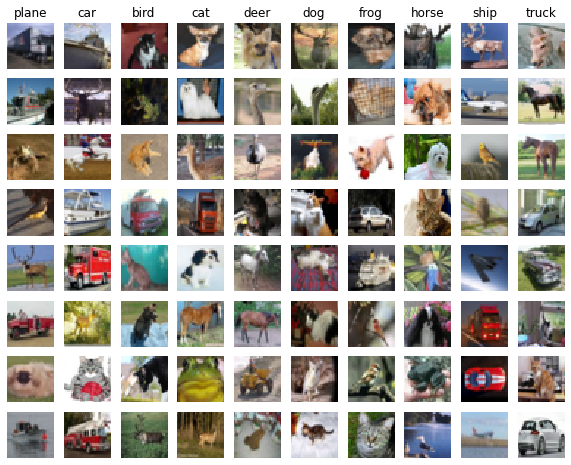

In [15]:
# 要想获得算法是如何工作的直观感受，一个重要的方式是可视化出错的地方
# 我们可视化分类错误的图片，例如第一列是我们的 SVM 标注的飞机类

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace = False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

观察如上可视化的结果，是否能有一些发现？

因为我们使用颜色直方图特征和 HOG 特征处理一些具有特殊背景或轮廓的错误分类，这样做是有意义的。例如，具有蓝色背景的对象往往被错误分类为飞机，而一些狗（或者卡车）往往被错误分类为猫（或者汽车）

## Neural Network on features


In [16]:
print(X_train_feats.shape)

(49000, 145)


In [19]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

results = {}
best_val = -1
best_net = None

learning_rates = [1e-2 ,1e-1, 5e-1, 1, 5]
regularization_strengths = [1e-3, 5e-3, 1e-2, 1e-1, 0.5, 1]

for lr in learning_rates:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
        num_iters=1500, batch_size=200,
        learning_rate=lr, learning_rate_decay=0.95,
        reg= reg, verbose=False)
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        if val_acc > best_val:
            best_val = val_acc
            best_net = net         
        results[(lr,reg)] = val_acc

for lr, reg in sorted(results):
    val_acc = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg,  val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-02 reg 1.000000e-03 val accuracy: 0.138000
lr 1.000000e-02 reg 5.000000e-03 val accuracy: 0.191000
lr 1.000000e-02 reg 1.000000e-02 val accuracy: 0.206000
lr 1.000000e-02 reg 1.000000e-01 val accuracy: 0.098000
lr 1.000000e-02 reg 5.000000e-01 val accuracy: 0.087000
lr 1.000000e-02 reg 1.000000e+00 val accuracy: 0.107000
lr 1.000000e-01 reg 1.000000e-03 val accuracy: 0.510000
lr 1.000000e-01 reg 5.000000e-03 val accuracy: 0.496000
lr 1.000000e-01 reg 1.000000e-02 val accuracy: 0.479000
lr 1.000000e-01 reg 1.000000e-01 val accuracy: 0.373000
lr 1.000000e-01 reg 5.000000e-01 val accuracy: 0.087000
lr 1.000000e-01 reg 1.000000e+00 val accuracy: 0.079000
lr 5.000000e-01 reg 1.000000e-03 val accuracy: 0.561000
lr 5.000000e-01 reg 5.000000e-03 val accuracy: 0.535000
lr 5.000000e-01 reg 1.000000e-02 val accuracy: 0.513000
lr 5.000000e-01 reg 1.000000e-01 val accuracy: 0.390000
lr 5.000000e-01 reg 5.000000e-01 val accuracy: 0.079000
lr 5.000000e-01 reg 1.000000e+00 val accuracy: 0

In [20]:
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.553
